In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv('data.csv')

from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime

from sklearn.metrics import mean_squared_error

import seaborn as sns 

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df.head()

,SOUID,DATE,TG,Q_TG
0,127488,18760101,22,0
1,127488,18760102,25,0
2,127488,18760103,3,0
3,127488,18760104,-58,0
4,127488,18760105,-98,0


In [4]:
del df['SOUID']
del df['Q_TG']

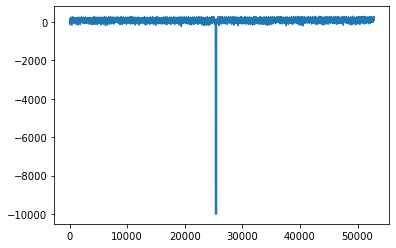

In [5]:
df['TG'].plot()              # check values, will need to fill in missing values

In [6]:
df.index[df['TG']<-800]

Int64Index([25316, 25317, 25318, 25319, 25320, 25321, 25322, 25323, 25324,
            25325,
            ...
            25501, 25502, 25503, 25504, 25505, 25506, 25507, 25508, 25509,
            25510],
           dtype='int64', length=195)

In [7]:
df.set_index(pd.to_datetime(df['DATE'].astype(str)), inplace=True)     # convert to datetime format
del(df['DATE'])
df['TG'] = df['TG'] / 10
df.head()

,TG
DATE,
1876-01-01,2.2
1876-01-02,2.5
1876-01-03,0.3
1876-01-04,-5.8
1876-01-05,-9.8


In [8]:
#df.drop(df[(df.index.month==2) & (df.index.day==29)], axis = 0)
dfsubset = df[(df.index.month==2) & (df.index.day==29)]                      # drop feb 29 values

In [9]:
df=df.drop(dfsubset.index)

In [10]:
patch44 = df.loc['1944/04/25':'1944/11/05', 'TG']                    ## fix the missing values
patch46 = df.loc['1946/04/25':'1946/11/05', 'TG']

avg = (patch44.values + patch46.values) / 2                          # mean of previous and next year

df.loc['1945/04/25':'1945/11/05', 'TG'] = avg

In [11]:
df.loc['1944/01/01':'1944/12/31', 'TG']

DATE
1944-01-01    1.8
1944-01-02    6.8
1944-01-03    5.3
1944-01-04    0.4
1944-01-05   -1.9
             ... 
1944-12-27   -6.6
1944-12-28   -3.4
1944-12-29   -5.2
1944-12-30   -4.0
1944-12-31   -0.8
Name: TG, Length: 365, dtype: float64

In [12]:
# add timestep values
df['timestep']=range(len(df.index))

In [13]:
df_train = df['1876-01':'1999-12'].copy()              # train-test split
df_test = df['2000-01':'2020-09'].copy()

In [14]:
plt.rcParams["figure.figsize"] = [20, 10]

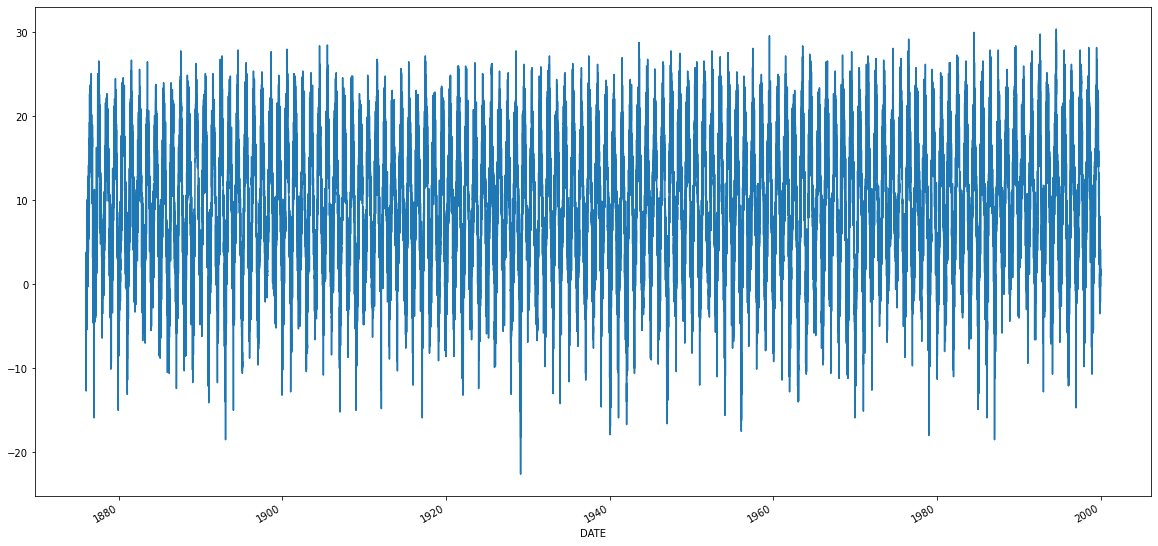

In [15]:
df_train['TG'].plot()

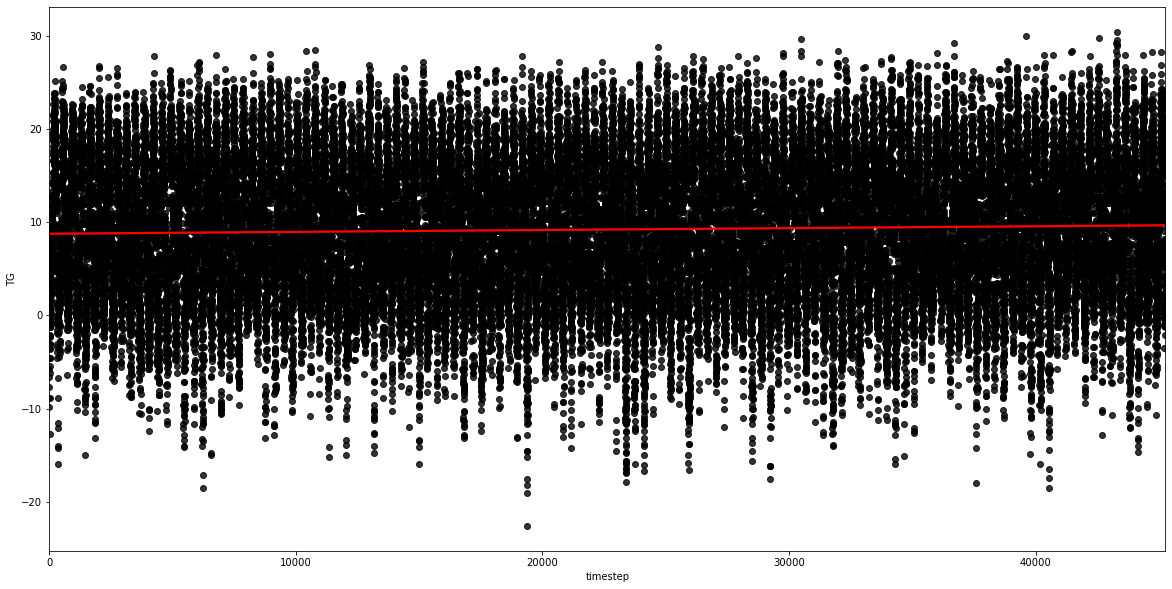

In [16]:
sns_plot = sns.regplot(x = 'timestep', y = 'TG', data = df_train, scatter_kws={"color": "black"}, line_kws={"color": "red"})

In [17]:
df_train.head()

,TG,timestep
DATE,,
1876-01-01,2.2,0
1876-01-02,2.5,1
1876-01-03,0.3,2
1876-01-04,-5.8,3
1876-01-05,-9.8,4


In [18]:
df_train['difference'] = df_train['TG'].diff(periods=1)             # Create difference column for removing trend

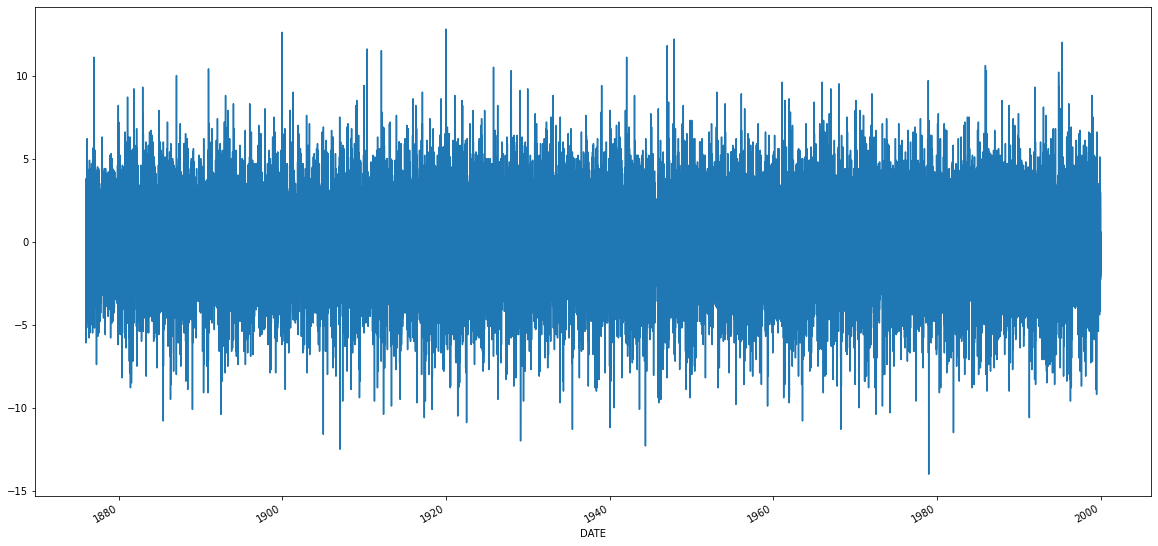

In [19]:
df_train['difference'].plot()

In [20]:
df_train['monthly mean'] = df_train.groupby(df_train.index.month)['difference'].transform('mean') # seasonality: create mean monthly difference column

In [21]:
monthlymeans = list(df_train.groupby(df_train.index.month)['difference'].mean()) # also save into a list

In [22]:
monthlymeans

[-0.007754358574030697,
 0.08309331797235031,
 0.14479708636836627,
 0.14723118279569825,
 0.17049947970863638,
 0.06573924731182815,
 0.03207596253902184,
 -0.0910509885535903,
 -0.1393413978494621,
 -0.18717481789802254,
 -0.12784946236559122,
 -0.08459937565036431]

In [23]:
df_train['deseasonalized'] = df_train['difference'] - df_train['monthly mean']

In [24]:
df_train['deseasonalized']

DATE
1876-01-01         NaN
1876-01-02    0.307754
1876-01-03   -2.192246
1876-01-04   -6.092246
1876-01-05   -3.992246
                ...   
1999-12-27   -1.015401
1999-12-28    0.284599
1999-12-29    0.284599
1999-12-30    0.684599
1999-12-31   -1.915401
Name: deseasonalized, Length: 45260, dtype: float64

In [25]:
ypred=df_train['deseasonalized'].mean()   # baseline (mean) prediction after trend and seasonality is removed

In [26]:
ypred

2.742012189677191e-17

In [27]:
df_train.head()

,TG,timestep,difference,monthly mean,deseasonalized
DATE,,,,,
1876-01-01,2.2,0,NaN,-0.007754,NaN
1876-01-02,2.5,1,0.3,-0.007754,0.307754
1876-01-03,0.3,2,-2.2,-0.007754,-2.192246
1876-01-04,-5.8,3,-6.1,-0.007754,-6.092246
1876-01-05,-9.8,4,-4.0,-0.007754,-3.992246


In [28]:
df_test.head()

,TG,timestep
DATE,,
2000-01-01,1.4,45260
2000-01-02,3.9,45261
2000-01-03,5.9,45262
2000-01-04,5.3,45263
2000-01-05,3.0,45264


In [29]:
df_test['TGPRED']=0    # this will be the prediction column

In [30]:
currmonth = df_test[df_test['timestep']==45260].index.month[0]        # let's predict the first step of the test dataframe
ypred_reconstruced = ypred + monthlymeans[currmonth-1]                # add back monthly mean
# De-diff using the last observed value from the train dataframe:
ypred_temp_reconstruced = df_train[df_train['timestep']==45259]['TG'][0] + ypred_reconstruced
df_test.loc[df_test['timestep']==45260,'TGPRED'] = ypred_temp_reconstruced

In [31]:
df_test.head()

,TG,timestep,TGPRED
DATE,,,
2000-01-01,1.4,45260,-0.207754
2000-01-02,3.9,45261,0.000000
2000-01-03,5.9,45262,0.000000
2000-01-04,5.3,45263,0.000000
2000-01-05,3.0,45264,0.000000


In [32]:
# Do the prediction for the test dataframe step by step:
for i in range(45261, 52833):
    currmonth = df_test[df_test['timestep']==i].index.month[0]
    ypred_reconstruced = ypred + monthlymeans[currmonth-1]
    ypred_temp_reconstruced = df_test[df_test['timestep']==i-1]['TGPRED'][0] + ypred_reconstruced
    df_test.loc[df_test['timestep']==i,'TGPRED'] = ypred_temp_reconstruced

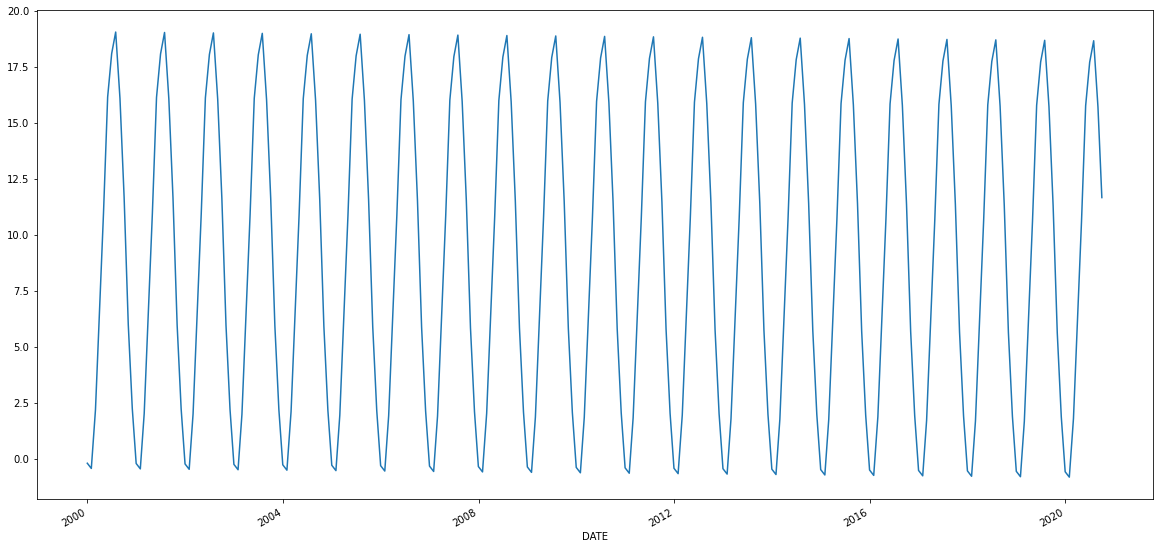

In [33]:
df_test['TGPRED'].plot()

In [34]:
del df_test['timestep']            # don't really need this anymore after prediction

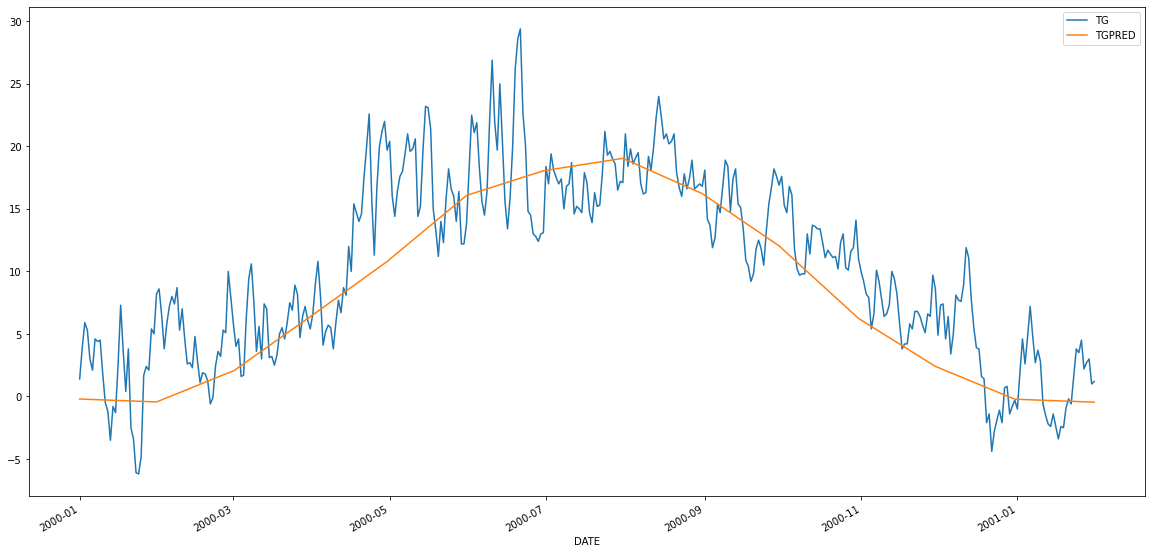

In [35]:
df_test['2000-01':'2001-01'].plot()          # display baseline model for a year

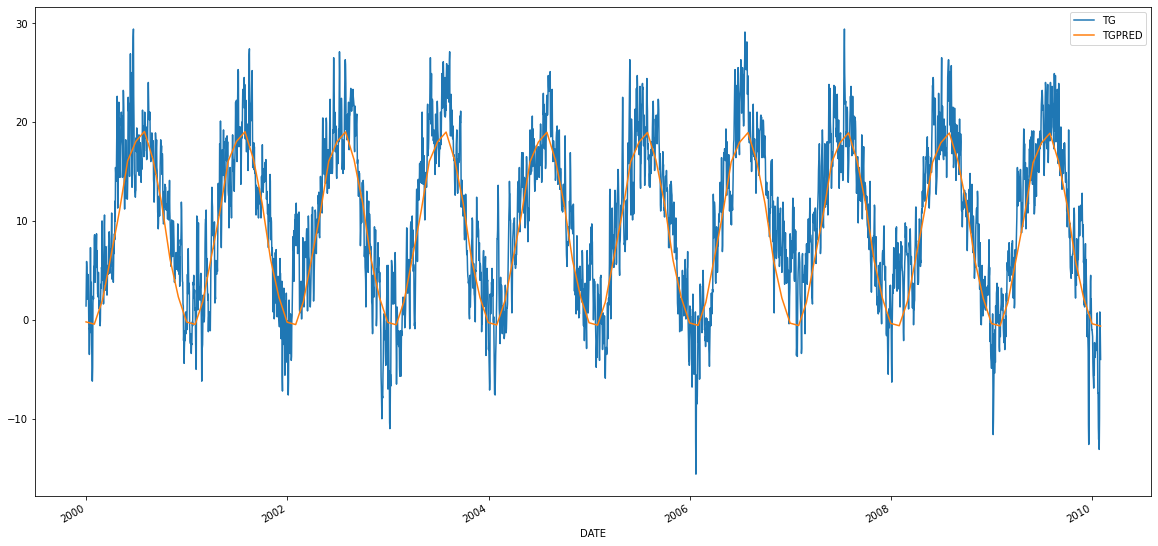

In [36]:
df_test['2000-01':'2010-01'].plot()          

In [38]:
print(mean_squared_error(df_test['TG'], df_test['TGPRED']))

17.073294809775316


In [40]:
df_test['2000-01':'2010-01']

,TG,TGPRED
DATE,,
2000-01-01,1.4,-0.207754
2000-01-02,3.9,-0.215509
2000-01-03,5.9,-0.223263
2000-01-04,5.3,-0.231017
2000-01-05,3.0,-0.238772
...,...,...
2010-01-27,-10.0,-0.603541
2010-01-28,0.8,-0.611296
2010-01-29,0.6,-0.619050
